# PCA of different Panels * Datasets

In [2]:
%%time
%load_ext autoreload
%autoreload 2

%matplotlib inline

from components.panel import Panel
from components.dataset import Dataset

from os.path import expanduser, join

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pca.pca_generator import PCAGenerator
from pca.pca_plotter import PCAPlotter


pca_generator = PCAGenerator()
pca_plotter = PCAPlotter()

CPU times: user 780 ms, sys: 224 ms, total: 1 s
Wall time: 1.31 s


GAL_Completo · 445 AIMs
Latinos, Europeos, Africanos, Chinos, Indios
LEACI__GAL_Completo__PCx10


/home/juan/repos/tesina/pca/pca_generator.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  genotypes.dropna(axis=1, inplace=True)


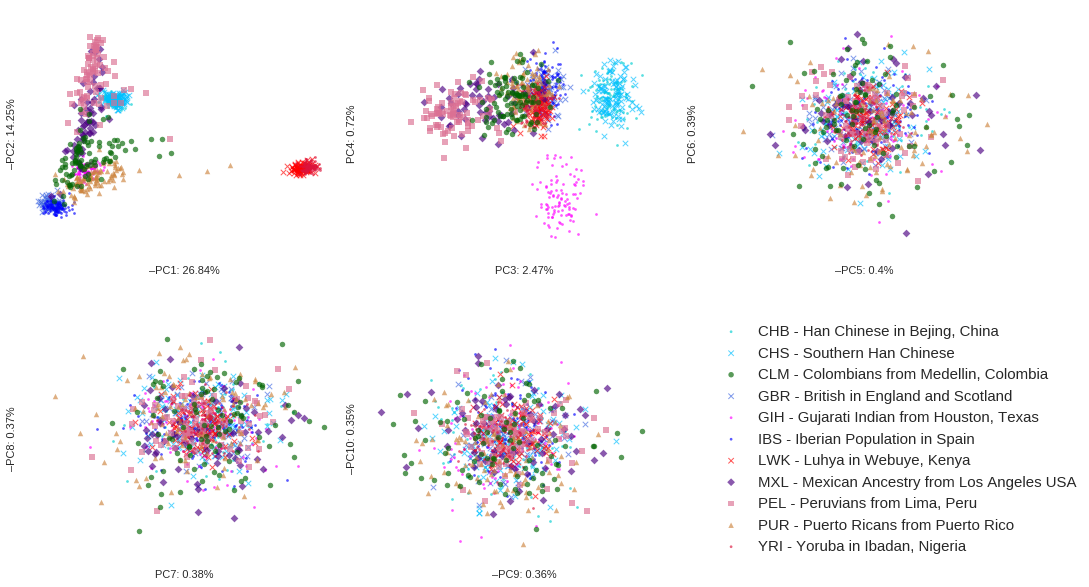

CPx100 · 43,144 SNPs
Latinos, Europeos, Africanos, Chinos, Indios
LEACI__CPx100__PCx10


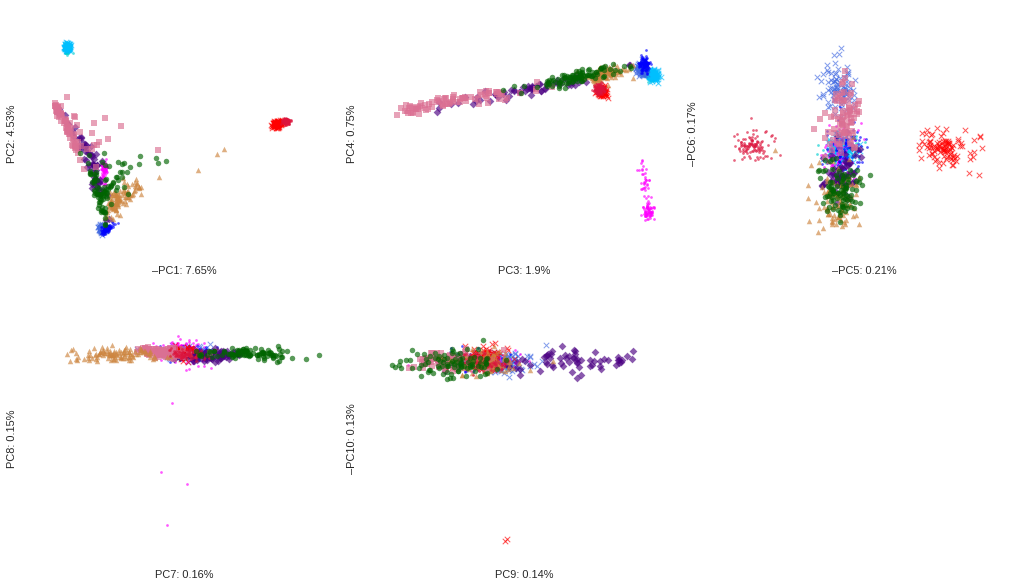

In [12]:
sns.set_context("notebook")
sns.set_style("white")


def make_filename(dataset_label, panel_label, components_to_compare):
    return "{}__{}__PCx{}".format(dataset_label, panel_label,
                                  len(components_to_compare) * 2)


datasets = [Dataset("LEACI")]
panels = [Panel("GAL_Completo"), Panel("CPx100")]



for normalize in [False]:

    for dataset in datasets:      

        for panel in panels:
            components = [("PC1", "PC2"), ("PC3", "PC4"), ("PC5", "PC6"),
                          ("PC7", "PC8"), ("PC9", "PC10")]

            caption = "{}\n{}".format(panel.name, dataset.name)
            filename = make_filename(dataset.label, panel.label, components)
            genotypes = panel.genotypes_1000G(dataset=dataset)

            if normalize:
                filename += "_normalized"
                caption += "_normalized"
            
            legend_on = panel is panels[0]
            pca_df, explained_var = pca_generator.run(genotypes, normalize=normalize)
            ax = pca_plotter.plot_(pca_df, explained_var, "", filename, components,
                                   legend_on=legend_on)
            
            print(caption)
            print(filename)
            plt.show()

## Generate subpanels from GAL_Affy to check the dispersion of the clusters

In [31]:
from shutil import copy2
from glob import glob
from os.path import basename
from subprocess import call


# Choose the desired snp counts of the subpanels and the source panel
panel = Panel("GAL_Affy")
subpanel_lengths = [100, 50, 25, 20, 15, 12, 10, 6, 5]
PANELS_DIR = expanduser("~/tesina/1000Genomes/all_panels")

for length in subpanel_lengths:
    panel.generate_subset_SNP_list(length)
    # ^ Generates .snps files in ~/tesina/panel_info_files

subpanel_files = glob(expanduser("~/tesina/panel_info_files/*_from_*.snps"))
# ^ _from_ is in the generated subpanel filenames

# Use plink to generate the .bed files for the new subpanel
for fpath in subpanel_files:
    label = basename(fpath).replace(".snps", "")
    command = ["plink", "--bfile", join(PANELS_DIR, panel.label),
               "--extract", fpath, "--make-bed", "--out", join(PANELS_DIR, label)]
    call(command)
    
subpanel_bfiles = glob(join(PANELS_DIR, "*_from_*.bed"))

# Use plink to get .traw files
for fpath in subpanel_bfiles:
    label = join(fpath.replace(".bed", ""))
    command = ["plink", "--bfile", label,
               "--recode", "A-transpose", "--out", label]
    call(command)

## Plot the subpanels in group

Subsets de GAL_Affy · Latinos, Europeos, Africanos (Normalized values)
/home/juan/tesina/charts/PCAs/LEA_GAL_Affy_subsets_normalized


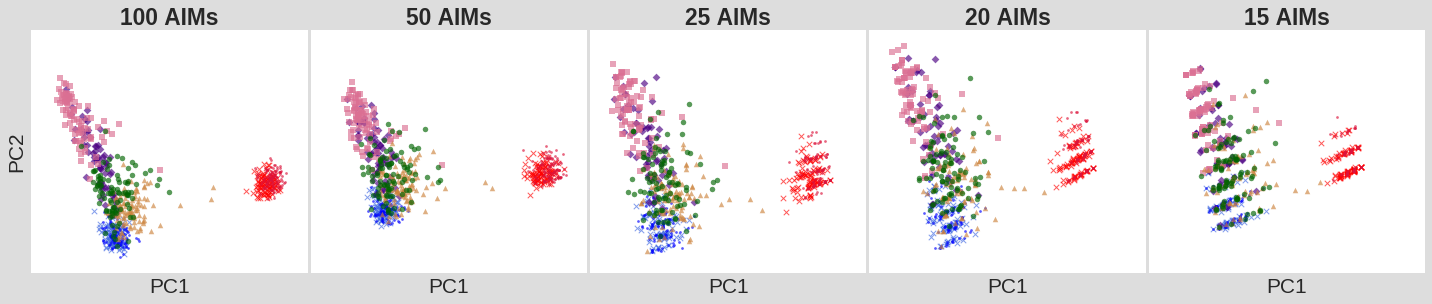

Subsets de GAL_Affy · Latinos, Europeos, Africanos
/home/juan/tesina/charts/PCAs/LEA_GAL_Affy_subsets


/home/juan/repos/tesina/pca/pca_generator.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  genotypes.dropna(axis=1, inplace=True)


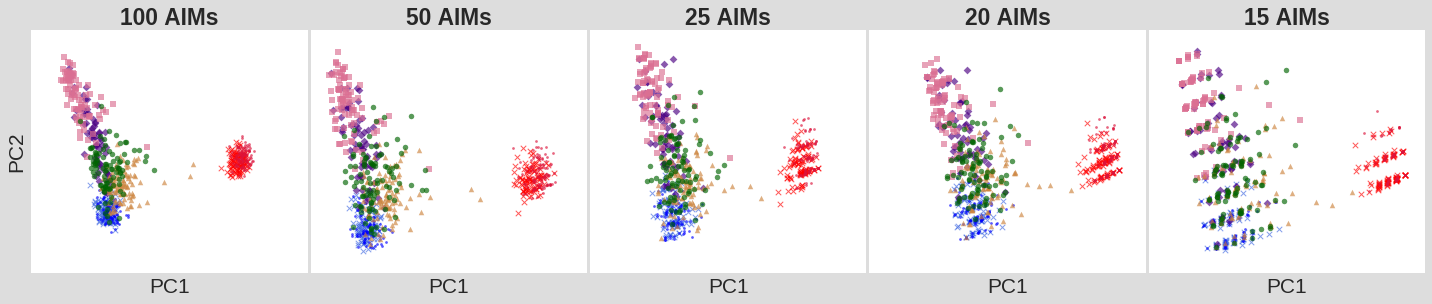

In [5]:
from itertools import product


sns.set_context("notebook", font_scale=1.9)
sns.set_style("white")

components_to_compare = ("PC1", "PC2")
base_panel_label = "GAL_Affy"
subpanels = Panel.all_subpanels(base_panel_label)[:5]

for normalize, dataset in product([True, False], Dataset.all_datasets()):
    if dataset.label != "LEA":
        continue
    
    plot_width, plot_height = 5, 5
    nrows, ncols = 1, (len(Panel.all_subpanels()) + 1)
    ax_ids = list(np.arange(nrows * ncols) + 1)
    fig = plt.figure(figsize=(plot_width * ncols, plot_height * nrows),
                     facecolor="#dddddd")
    
    first_plot = True
    for subpanel in subpanels:
        
        pretty_name = subpanel.name.split(" from ")[0]
        genotypes = subpanel.genotypes_1000G(dataset=dataset)
        pca_df, explained_var = pca_generator.run(genotypes, normalize=normalize)
        ax = fig.add_subplot(nrows, ncols, ax_ids.pop(0))
        ax = pca_plotter.draw_ax(ax, components_to_compare, pca_df, explained_var,
                                 reference_population="PEL", title=pretty_name)
        ax.set_xlabel("PC1")
        ax.set_ylabel("")
        if first_plot:
            ax.set_ylabel("PC2")
            first_plot = False

#         fig.suptitle(suptitle, fontsize=20, x=0.125, ha="left",
#                      family="serif", fontweight="bold")
        plt.subplots_adjust(wspace=0.01, top=0.8)
        
    caption = "{} · {}".format("Subsets de {}".format(base_panel_label), dataset.name)
    if normalize:
        caption += " (Normalized values)"
    print(caption)
    
    filename = "{}_{}_subsets".format(dataset.label, base_panel_label)
    if normalize:
        filename += "_normalized"
    filepath = join(pca_plotter.FIGS_DIR, filename)
    print(filepath)
    
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()


# Group plots per dataset!

PCA con las muestras del dataset LEA (control_panels)
/home/juan/tesina/charts/PCAs/LEA__control_panels__normalized
PCA con las muestras del dataset LEA (panels)
/home/juan/tesina/charts/PCAs/LEA__panels__normalized
PCA con las muestras del dataset LEA (subpanels)
/home/juan/tesina/charts/PCAs/LEA__subpanels__normalized
PCA con las muestras del dataset LEAC (control_panels)
/home/juan/tesina/charts/PCAs/LEAC__control_panels__normalized
PCA con las muestras del dataset LEAC (panels)
/home/juan/tesina/charts/PCAs/LEAC__panels__normalized
PCA con las muestras del dataset LEAC (subpanels)
/home/juan/tesina/charts/PCAs/LEAC__subpanels__normalized


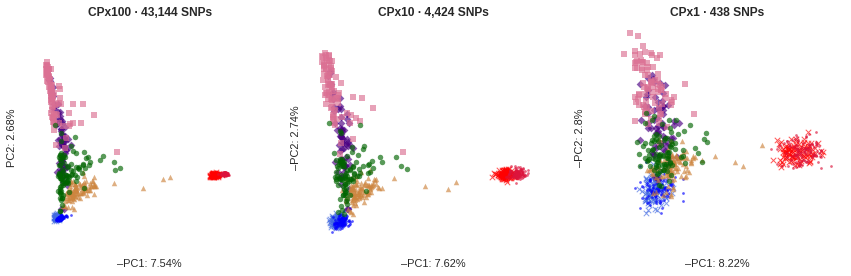

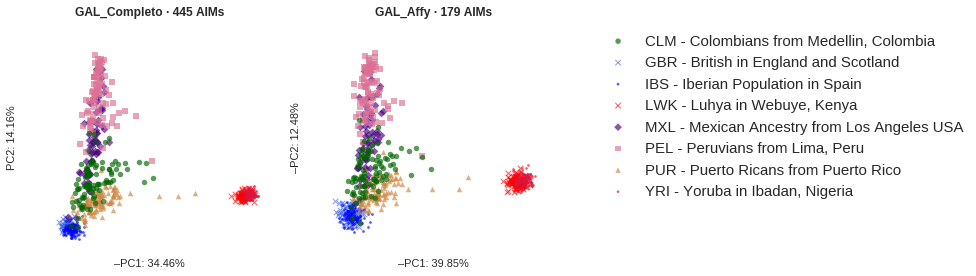

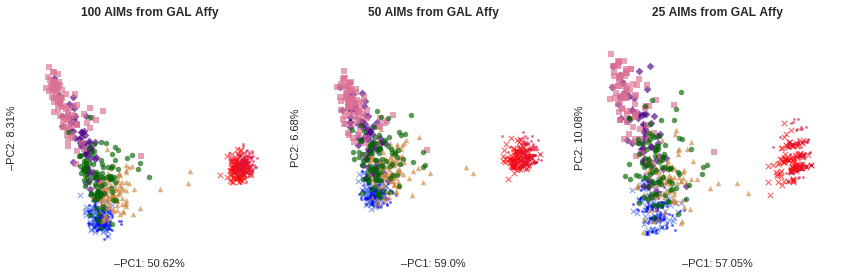

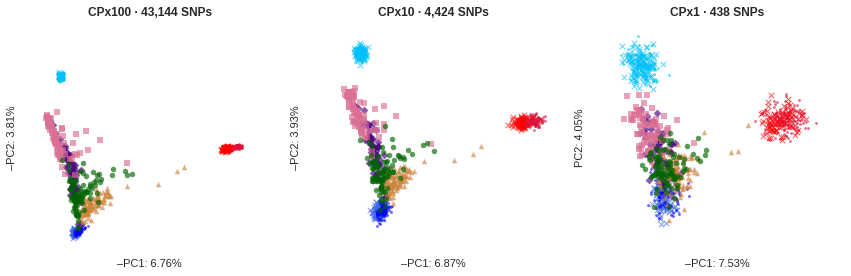

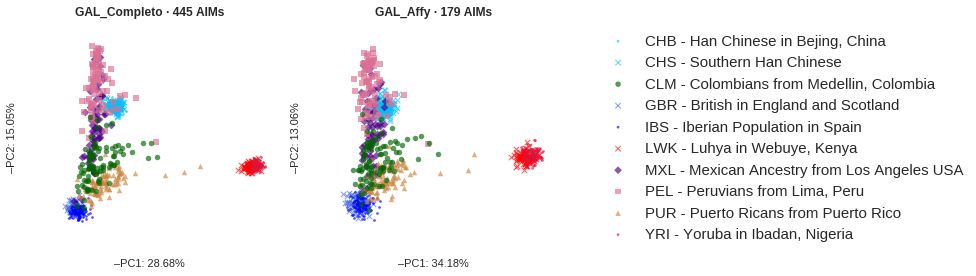

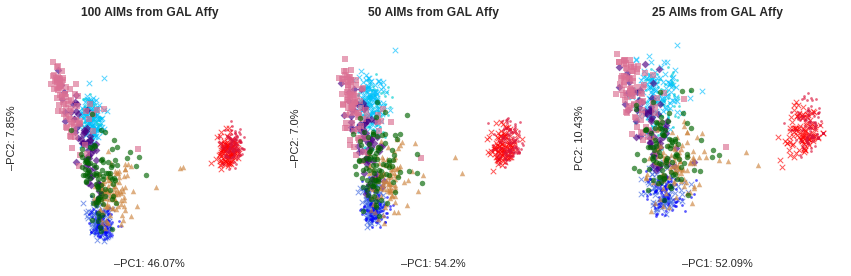

In [7]:
from helpers.plot_helpers import legend_subplot
from sources.thousand_genomes import ThousandGenomes


sns.set_context("notebook")
sns.set_style("white")

fdir = expanduser("~/tesina/charts/PCAs")
normalize = True

panel_groups = Panel.panel_groups()
panel_groups["panels"] = panel_groups["panels"][:2][::-1]
panel_groups["subpanels"] = panel_groups["subpanels"][:3]
panel_groups["control_panels"].reverse()

datasets = [Dataset("LEA"), Dataset("LEAC")]

for dataset in datasets:
    
    for panel_group_label, panel_group in panel_groups.items():
        caption = "PCA con las muestras del dataset {} ({})".format(dataset.label, panel_group_label)
        print(caption)

        plotw, ploth = 4, 4
        ncols, nrows = 3, 1
        fig = plt.figure(figsize=(plotw * ncols, ploth * nrows))
        ax_ids = list(np.arange(ncols * nrows) + 1)

        # Draw the plot
        for panel in panel_group:
            ax = fig.add_subplot(nrows, ncols, ax_ids.pop(0))
            title = panel.name
            
            genotypes = panel.genotypes_1000G(dataset=dataset)
            pca_df, explained_var = pca_generator.run(genotypes, normalize=normalize)
            pca_plotter.draw_ax(ax, ("PC1", "PC2"), pca_df, explained_var, "PEL", title)

        # Draw the legend "plot"
        if panel_group_label == "panels":
            handles, labels = ax.get_legend_handles_labels()
            populations_df = ThousandGenomes.population_names()
            descriptions = populations_df.ix[labels, "description"]
            labels = [" - ".join([code, desc])
                      for code, desc in descriptions.iteritems()]

            ax = fig.add_subplot(nrows, ncols, ax_ids.pop(0))
            legend_subplot(ax, handles, labels)

        # Save & display the fig
        filename = "{}__{}".format(dataset.label, panel_group_label)
        if normalize:
            filename += "__normalized"

        filepath = join(fdir, filename)
        print(filepath)

        plt.tight_layout(h_pad=2.0)    
        plt.savefig(filepath, bbox_inches="tight")
        plt.show    